## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np

import os
os.chdir("D:\\data\\titanic")

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import partner as ally
import math

In [2]:
train = pd.read_csv("train_imputed.csv")
test = pd.read_csv("test_imputed.csv")

In [3]:
print(train.shape)
print(test.shape)

(886, 13)
(418, 12)


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NA
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,0


## EDA

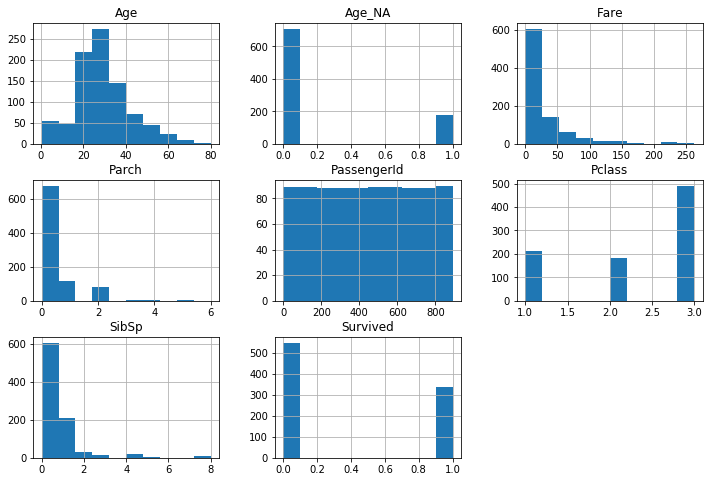

In [5]:
plt.rcParams['figure.figsize']=(12,8)
f = train.hist()

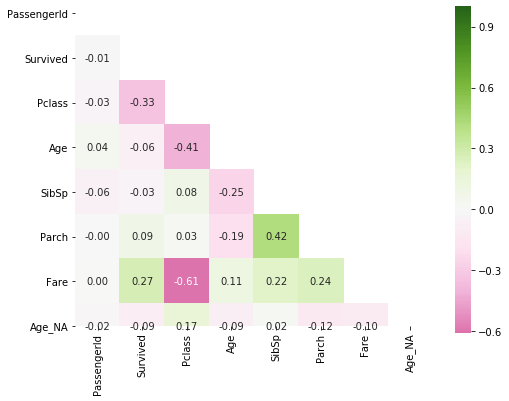

In [6]:
plt.rcParams['figure.figsize']=(8,6)
corr = train.corr()
f = sns.heatmap(corr,center=0,mask=np.triu(np.ones_like(corr)),cmap='PiYG',annot=True,fmt='.2f',square=True)

## Data Preparation

> ### Data Discovery

**FamilySize**

In [7]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

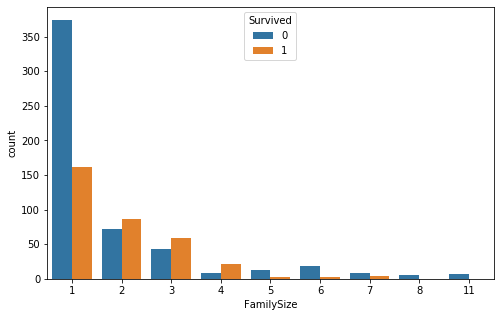

In [8]:
plt.rcParams['figure.figsize']=(8,5)
f = sns.countplot(data=train,x='FamilySize',hue='Survived')

In [9]:
FamilySize_dict = {
    1: 'Alone',
    2: 'Small',
    3: 'Small',
    4: 'Small',
    5: 'Medium',
    6: 'Medium',
    7: 'Medium',
    8: 'Large',
    11: 'Large',
}

In [10]:
train['FamilyType'] = train.FamilySize.map(FamilySize_dict)
test['FamilyType'] = test.FamilySize.map(FamilySize_dict)

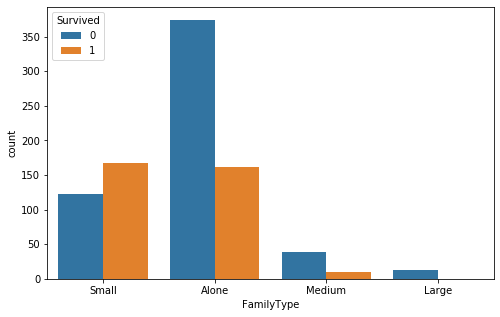

In [11]:
f = sns.countplot(data=train,x='FamilyType',hue='Survived')

**SurnameSurvivalRate** 
1. encode training, map to test, fill test with survival probability of [Class,Sex,Cabin,Embarked]
2. OTHER_OPTION : encode common items and add indicator for missing in train and test

In [12]:
train['Surname'] = train.Name.str.split('.',expand=True)[0].str.split(', ',expand=True)[0]
test['Surname'] = test.Name.str.split('.',expand=True)[0].str.split(', ',expand=True)[0]

In [13]:
train.Surname.nunique()

664

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NA,FamilySize,FamilyType,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,0,2,Small,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,0,2,Small,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,0,1,Alone,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,0,2,Small,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,0,1,Alone,Allen


In [15]:
# let find out the common surname
common_surname = set(train.Surname)&set(test.Surname)

In [16]:
chance = round(train.Survived.mean(),2)

In [17]:
surname_map = train.groupby(by=['Surname'])['Survived'].median().round(2).to_dict()

In [18]:
train['SurnameSurvivalRate'] = [0]*len(train)
train['SurnameSurvivalRate_NA']=[0]*len(train)

In [19]:
for i in range(0,len(train)):
    if (train.loc[i,"FamilySize"]>1)&(train.loc[i,"Surname"] in common_surname):
        train.loc[i,'SurnameSurvivalRate'] = surname_map.get(train.loc[i,"Surname"])
        train.loc[i,'SurnameSurvivalRate_NA'] = 1
    else:
        train.loc[i,'SurnameSurvivalRate'] = chance
        train.loc[i,'SurnameSurvivalRate_NA'] = 0

In [20]:
test['SurnameSurvivalRate'] = [0]*len(test)
test['SurnameSurvivalRate_NA']=[0]*len(test)

In [21]:
for i in range(0,len(test)):
    if (test.loc[i,"FamilySize"]>1)&(test.loc[i,"Surname"] in common_surname):
        test.loc[i,'SurnameSurvivalRate'] = surname_map.get(test.loc[i,"Surname"])
        test.loc[i,'SurnameSurvivalRate_NA'] = 1
    else:
        test.loc[i,'SurnameSurvivalRate'] = chance
        test.loc[i,'SurnameSurvivalRate_NA'] = 0

In [22]:
ally.eda.print_null_cntNpct([train,test])

Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
All Missing Column  in the data frames : 

set()


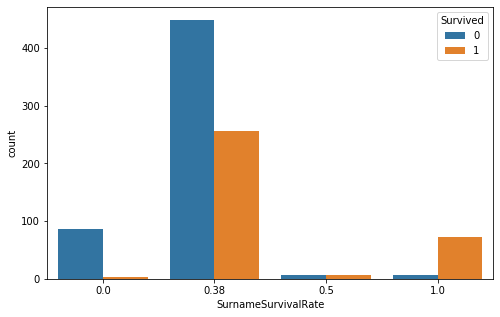

In [23]:
f = sns.countplot(data=train,x='SurnameSurvivalRate',hue='Survived')

**TicketFrequency**

In [24]:
train['TicketFrequency'] = train.groupby(by=['Ticket'])['Ticket'].transform('count')
test['TicketFrequency'] = test.groupby(by=['Ticket'])['Ticket'].transform('count')

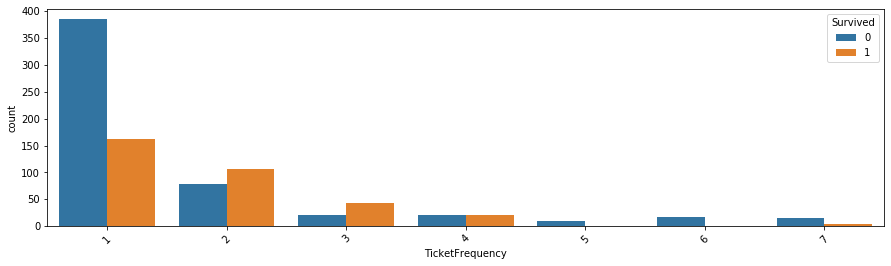

In [25]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='TicketFrequency',hue='Survived')

In [26]:
train.TicketFrequency.replace([5,6], 56,inplace=True)

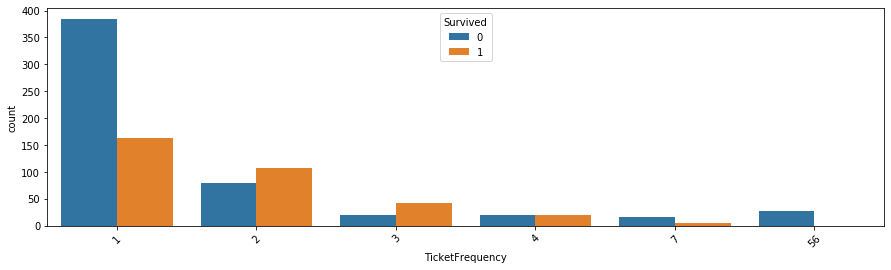

In [27]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='TicketFrequency',hue='Survived')

**TicketSurvivalRate**

In [28]:
# let find out the common ticket
common_ticket = set(train.Ticket) & set(test.Ticket)

In [29]:
ticket_map = train.groupby(by=['Ticket'])['Survived'].median().round(2).to_dict()

In [30]:
train['TicketSurvivalRate'] = [0]*len(train)
train['TicketSurvivalRate_NA']=[0]*len(train)

test['TicketSurvivalRate'] = [0]*len(test)
test['TicketSurvivalRate_NA']=[0]*len(test)

In [31]:
for i in range(0,len(train)):
    if (train.loc[i,"FamilySize"]>1)&(train.loc[i,"Ticket"] in common_ticket):
        train.loc[i,'TicketSurvivalRate'] = ticket_map.get(train.loc[i,"Ticket"])
        train.loc[i,'TicketSurvivalRate_NA'] = 1
    else:
        train.loc[i,'TicketSurvivalRate'] = chance
        train.loc[i,'TicketSurvivalRate_NA'] = 0

In [32]:
for i in range(0,len(test)):
    if (test.loc[i,"FamilySize"]>1)&(test.loc[i,"Ticket"] in common_ticket):
        test.loc[i,'TicketSurvivalRate'] = ticket_map.get(test.loc[i,"Ticket"])
        test.loc[i,'TicketSurvivalRate_NA'] = 1
    else:
        test.loc[i,'TicketSurvivalRate'] = chance
        test.loc[i,'TicketSurvivalRate_NA'] = 0

In [33]:
ally.eda.print_null_cntNpct([train,test])

Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
All Missing Column  in the data frames : 

set()


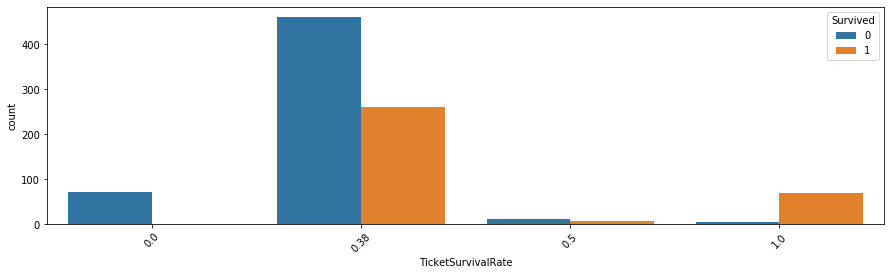

In [34]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='TicketSurvivalRate',hue='Survived')

**SurvivalRate**

In [35]:
train['SurvivalRate'] = (train.SurnameSurvivalRate + train.TicketSurvivalRate)/2
test['SurvivalRate'] = (test.SurnameSurvivalRate + test.TicketSurvivalRate)/2

In [36]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_NA,FamilySize,FamilyType,Surname,SurnameSurvivalRate,SurnameSurvivalRate_NA,TicketFrequency,TicketSurvivalRate,TicketSurvivalRate_NA,SurvivalRate
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,2,Small,Braund,0.38,0,1,0.38,0,0.38
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,2,Small,Cumings,1.00,1,1,1.00,1,1.00
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,Alone,Heikkinen,0.38,0,1,0.38,0,0.38
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,Small,Futrelle,0.38,0,2,0.38,0,0.38
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,Alone,Allen,0.38,0,1,0.38,0,0.38


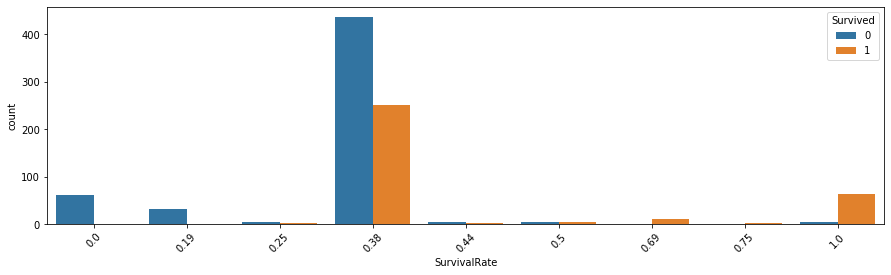

In [37]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='SurvivalRate',hue='Survived')

**Salutation**

In [38]:
train['Salutation'] = train.Name.str.split('.',expand=True)[0].str.split(', ',expand=True)[1]
test['Salutation'] = test.Name.str.split('.',expand=True)[0].str.split(', ',expand=True)[1]

In [39]:
train.Salutation.value_counts()

Mr              514
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Capt              1
Lady              1
Ms                1
Sir               1
Mme               1
the Countess      1
Don               1
Jonkheer          1
Name: Salutation, dtype: int64

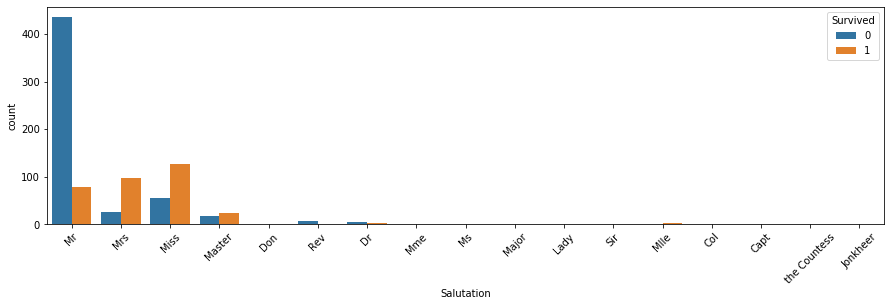

In [40]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='Salutation',hue='Survived')

**is_married**

In [41]:
train['is_married']= np.where(train.Salutation == 'Mrs',1,0)
test['is_married']= np.where(test.Salutation == 'Mrs',1,0)

In [42]:
train.Salutation.replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms',inplace=True)
test.Salutation.replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms',inplace=True)

In [43]:
train.Salutation.replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy',inplace=True)
test.Salutation.replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy',inplace=True)

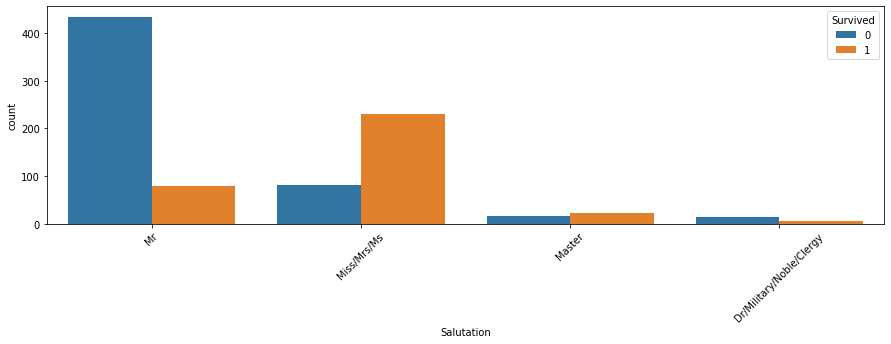

In [44]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='Salutation',hue='Survived')

**Cabin**

In [45]:
pd.crosstab(index=train.Cabin,columns=train.Pclass,values=train.Survived,aggfunc='count')

Pclass,1,2,3
Cabin,,,
A,15.0,NaN,NaN
B,44.0,NaN,NaN
C,58.0,NaN,NaN
D,29.0,4.0,NaN
E,25.0,4.0,3.0
F,NaN,8.0,5.0
G,NaN,NaN,4.0
M,39.0,168.0,479.0
T,1.0,NaN,NaN


In [46]:
df = train.pivot_table(index='Pclass',columns='Cabin',values='Survived',aggfunc='count',fill_value=0)

In [47]:
df = df/df.sum()

<BarContainer object of 9 artists>

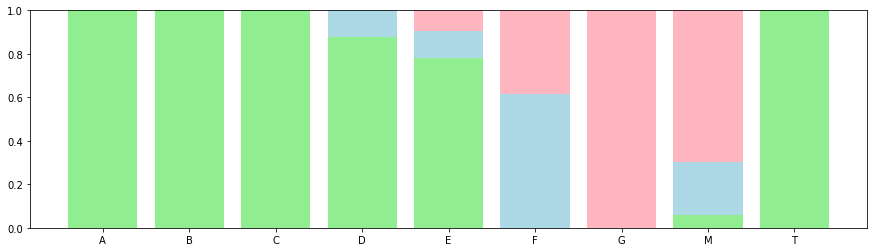

In [48]:
plt.bar(x=df.T.index,height=df.loc[1,],color='lightgreen',label='Class 1')
plt.bar(x=df.T.index,bottom=df.loc[1,],height=df.loc[2,],color='lightblue',label='Class 2')
plt.bar(x=df.T.index,bottom=df.loc[1,]+df.loc[2,],height=df.loc[3,],color='lightpink',label='Class 3')

In [49]:
train.Cabin.replace(['A','B','C','T'], 'ABCT',inplace=True)
test.Cabin.replace(['A','B','C','T'], 'ABCT',inplace=True)

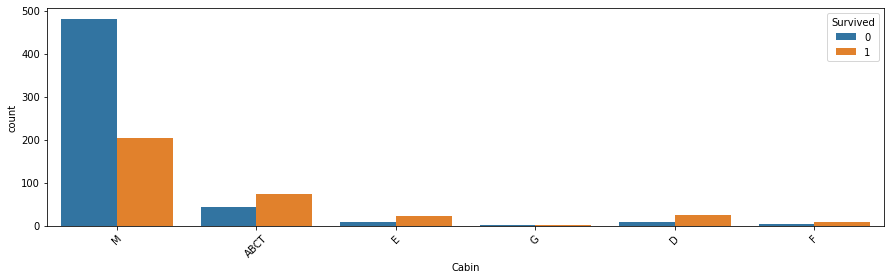

In [50]:
plt.rcParams['figure.figsize']=(15,4)
plt.xticks(rotation=45)
f = sns.countplot(data=train,x='Cabin',hue='Survived')

**Cleanup**

In [51]:
del train['Name']
del test['Name']

del train['Ticket']
del test['Ticket']

del train['Surname']
del test['Surname']

In [52]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,FamilySize,FamilyType,SurnameSurvivalRate,SurnameSurvivalRate_NA,TicketFrequency,TicketSurvivalRate,TicketSurvivalRate_NA,SurvivalRate,Salutation,is_married
0,1,0,3,male,22.0,1,0,7.2500,M,S,...,2,Small,0.38,0,1,0.38,0,0.38,Mr,0
1,2,1,1,female,38.0,1,0,71.2833,ABCT,C,...,2,Small,1.00,1,1,1.00,1,1.00,Miss/Mrs/Ms,1
2,3,1,3,female,26.0,0,0,7.9250,M,S,...,1,Alone,0.38,0,1,0.38,0,0.38,Miss/Mrs/Ms,0
3,4,1,1,female,35.0,1,0,53.1000,ABCT,S,...,2,Small,0.38,0,2,0.38,0,0.38,Miss/Mrs/Ms,1
4,5,0,3,male,35.0,0,0,8.0500,M,S,...,1,Alone,0.38,0,1,0.38,0,0.38,Mr,0


In [53]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_NA,FamilySize,FamilyType,SurnameSurvivalRate,SurnameSurvivalRate_NA,TicketFrequency,TicketSurvivalRate,TicketSurvivalRate_NA,SurvivalRate,Salutation,is_married
0,892,3,male,34.5,0,0,7.8292,M,Q,0,1,Alone,0.38,0,1,0.38,0,0.38,Mr,0
1,893,3,female,47.0,1,0,7.0000,M,S,0,2,Small,0.38,0,1,0.38,0,0.38,Miss/Mrs/Ms,1
2,894,2,male,62.0,0,0,9.6875,M,Q,0,1,Alone,0.38,0,1,0.38,0,0.38,Mr,0
3,895,3,male,27.0,0,0,8.6625,M,S,0,1,Alone,0.38,0,1,0.38,0,0.38,Mr,0
4,896,3,female,22.0,1,1,12.2875,M,S,0,3,Small,1.00,1,1,1.00,1,1.00,Miss/Mrs/Ms,1


> ### Discreatization

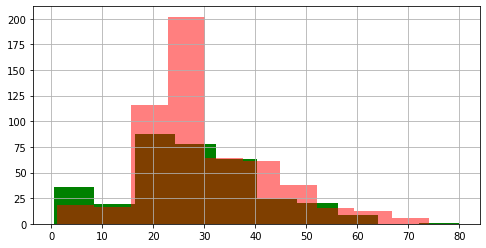

In [54]:
plt.rcParams['figure.figsize'] = (8,4)

b= 10
train[train.Survived==1]['Age'].hist(bins=b,color='green')
train[train.Survived==0]['Age'].hist(bins=b,color='r',alpha=0.5)

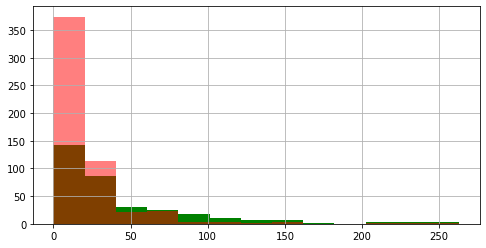

In [55]:
b= 13
train[train.Survived==1]['Fare'].hist(bins=b,color='green')
train[train.Survived==0]['Fare'].hist(bins=b,color='r',alpha=0.5)

> ### Transformation

In [56]:
y = train['Survived']
del train['Survived']

In [277]:
from feature_engine.variable_transformers import YeoJohnsonTransformer
transformer = YeoJohnsonTransformer(variables=['Age','Fare'])
transformer.fit(train)

train = transformer.transform(train)
test = transformer.transform(test)

In [57]:
from feature_engine.discretisers import EqualWidthDiscretiser
age_dsc = EqualWidthDiscretiser(bins=10,variables=['Age'])
fare_dsc = EqualWidthDiscretiser(bins=13,variables=['Fare'])

age_dsc.fit(train)
fare_dsc.fit(train)

EqualWidthDiscretiser(bins=13, return_object=False, variables=['Fare'])

In [58]:
train = age_dsc.transform(train)
test = age_dsc.transform(test)

In [59]:
train = fare_dsc.transform(train)
test = fare_dsc.transform(test)

> ### Encoding

In [60]:
train.Pclass.replace(1,'First',inplace=True)
train.Pclass.replace(2,'Second',inplace=True)
train.Pclass.replace(3,'Third',inplace=True)

test.Pclass.replace(1,'First',inplace=True)
test.Pclass.replace(2,'Second',inplace=True)
test.Pclass.replace(3,'Third',inplace=True)

In [61]:
one = ['Pclass','Sex','Cabin','Embarked','FamilyType','Salutation']

In [62]:
feature = test.columns.tolist()
feature.remove('PassengerId')
feature

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked',
 'Age_NA',
 'FamilySize',
 'FamilyType',
 'SurnameSurvivalRate',
 'SurnameSurvivalRate_NA',
 'TicketFrequency',
 'TicketSurvivalRate',
 'TicketSurvivalRate_NA',
 'SurvivalRate',
 'Salutation',
 'is_married']

In [64]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
ohe = OneHotCategoricalEncoder(variables=one,drop_last=True)
ohe.fit(train[feature])

OneHotCategoricalEncoder(drop_last=True, top_categories=None,
                         variables=['Pclass', 'Sex', 'Cabin', 'Embarked',
                                    'FamilyType', 'Salutation'])

In [65]:
ohe.encoder_dict_

{'Pclass': ['Third', 'First'],
 'Sex': ['male'],
 'Cabin': ['M', 'ABCT', 'E', 'G', 'D'],
 'Embarked': ['S', 'C'],
 'FamilyType': ['Small', 'Alone', 'Medium'],
 'Salutation': ['Mr', 'Miss/Mrs/Ms', 'Master']}

In [66]:
train = ohe.transform(train[feature])

In [67]:
test = ohe.transform(test[feature])

In [68]:
ally.eda.print_null_cntNpct([train,test])

Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []
All Missing Column  in the data frames : 

set()


In [69]:
train.head()

,Age,SibSp,Parch,Fare,Age_NA,FamilySize,SurnameSurvivalRate,SurnameSurvivalRate_NA,TicketFrequency,TicketSurvivalRate,...,Cabin_G,Cabin_D,Embarked_S,Embarked_C,FamilyType_Small,FamilyType_Alone,FamilyType_Medium,Salutation_Mr,Salutation_Miss/Mrs/Ms,Salutation_Master
0,2,1,0,0,0,2,0.38,0,1,0.38,...,0,0,1,0,1,0,0,1,0,0
1,4,1,0,3,0,2,1.00,1,1,1.00,...,0,0,0,1,1,0,0,0,1,0
2,3,0,0,0,0,1,0.38,0,1,0.38,...,0,0,1,0,0,1,0,0,1,0
3,4,1,0,2,0,2,0.38,0,2,0.38,...,0,0,1,0,1,0,0,0,1,0
4,4,0,0,0,0,1,0.38,0,1,0.38,...,0,0,1,0,0,1,0,1,0,0


In [70]:
x = train
y

0      0
1      1
2      1
3      1
4      0
      ..
881    0
882    1
883    0
884    1
885    0
Name: Survived, Length: 886, dtype: int64

### Modelling

In [71]:
pd.Series(y).value_counts(normalize=True)

0    0.61851
1    0.38149
Name: Survived, dtype: float64

In [72]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from imblearn.metrics import geometric_mean_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

Using TensorFlow backend.


In [73]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier,PassiveAggressiveClassifier
from sklearn.svm import SVC,NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [81]:
names = list()
values = list()

scaler = MinMaxScaler()

models_list = [#DummyClassifier(strategy='most_frequent'),
               Pipeline(steps=[('scale',scaler),('clf',LogisticRegression(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',RidgeClassifier(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',SVC(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',NuSVC(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',KNeighborsClassifier())]),
               Pipeline(steps=[('scale',scaler),('clf',RandomForestClassifier(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',ExtraTreesClassifier(class_weight='balanced'))]),
               Pipeline(steps=[('scale',scaler),('clf',AdaBoostClassifier())]),
               Pipeline(steps=[('scale',scaler),('clf',BaggingClassifier())]),
               Pipeline(steps=[('scale',scaler),('clf',GradientBoostingClassifier())])
              ]

In [82]:
print('**Mean G-Mean**')
for model in models_list:
    #name = ''.join([c for c in type(model).__name__ if c.isupper()]) # just the captial letter
    try:
        name = type(model['clf']).__name__
    except:
        name = type(model).__name__
        
    # evaluate the model
    scores = evaluate_model(x,y,model)
    
    # save result
    names.append(name)
    values.append(scores)
    
    # summarize performance
    print(f'{name} -> {scores.mean().round(3)} ({scores.std().round(3)})')

**Mean G-Mean**
LogisticRegression -> 0.845 (0.031)
RidgeClassifier -> 0.838 (0.035)
SVC -> 0.836 (0.032)
NuSVC -> 0.819 (0.036)
KNeighborsClassifier -> 0.811 (0.03)
RandomForestClassifier -> 0.817 (0.037)
ExtraTreesClassifier -> 0.817 (0.039)
AdaBoostClassifier -> 0.826 (0.034)
BaggingClassifier -> 0.795 (0.04)
GradientBoostingClassifier -> 0.823 (0.031)


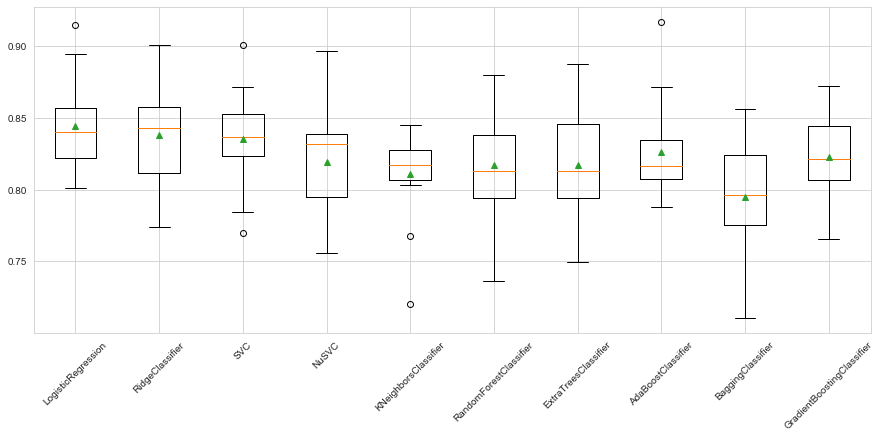

In [83]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(15,6)
plt.boxplot(values, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [84]:
model = LogisticRegression(class_weight='balanced')

In [85]:
scaler = MinMaxScaler()

### Modelling with OverSampling Techniques

In [86]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

In [87]:
# define oversampling models to test
def get_Omodels():
    models, names = list(), list()
    # RandomOverSampler
    models.append(RandomOverSampler())
    names.append('ROS')
    # SMOTE
    models.append(SMOTE())
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE())
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE())
    names.append('SVMSMOTE')
    # ADASYN
    models.append(ADASYN())
    names.append('ADASYN')
    
    return models, names

>ROS 0.841 (0.032)
>SMOTE 0.845 (0.033)
>BLSMOTE 0.833 (0.033)
>SVMSMOTE 0.840 (0.035)
>ADASYN 0.835 (0.035)


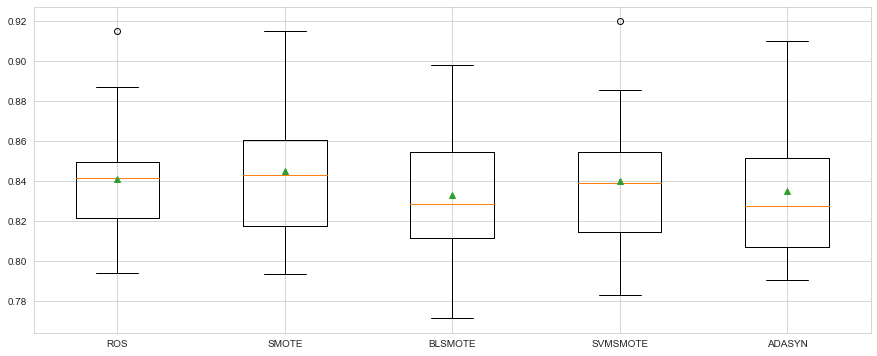

In [88]:
# define models
omodels, names = get_Omodels()
results = list()
# evaluate each model
for i in range(len(omodels)):
    # define the pipeline steps
    steps = [('scale', scaler), ('over', omodels[i]), ('clf', model)]
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(x, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Modelling with UnderSampling Techniques

In [89]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold

In [90]:
# define undersampling models to test
def get_Umodels():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')
    # ENN
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # OSS
    models.append(OneSidedSelection())
    names.append('OSS')
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    #InstanceHardnessThreshold
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    
    return models, names

>TL 0.843 (0.033)
>ENN 0.826 (0.036)
>RENN 0.812 (0.037)
>OSS 0.844 (0.033)
>NCR 0.833 (0.036)
>IHT 0.820 (0.035)


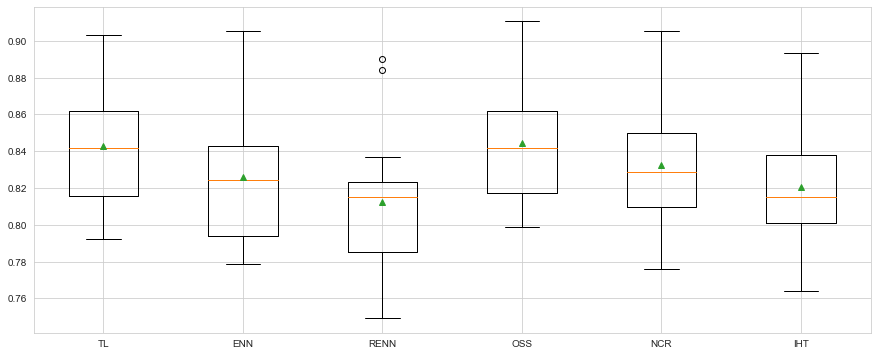

In [91]:
# define models
umodels, names = get_Umodels()
results = list()
# evaluate each model
for i in range(len(umodels)):
    # define the pipeline steps
    steps = [('scale', scaler), ('under', umodels[i]), ('clf', model)]
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(x, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Modelling with Combined Techniques

In [92]:
from imblearn.combine import SMOTEENN,SMOTETomek

In [93]:
# define undersampling models to test
def get_Cmodels():
    models, names = list(), list()
    # SMOTEENN
    models.append(SMOTEENN())
    names.append('SMOTEENN')
    # SMOTETomek
    models.append(SMOTETomek())
    names.append('SMOTETomek')

    return models, names

>SMOTEENN 0.834 (0.035)
>SMOTETomek 0.841 (0.031)


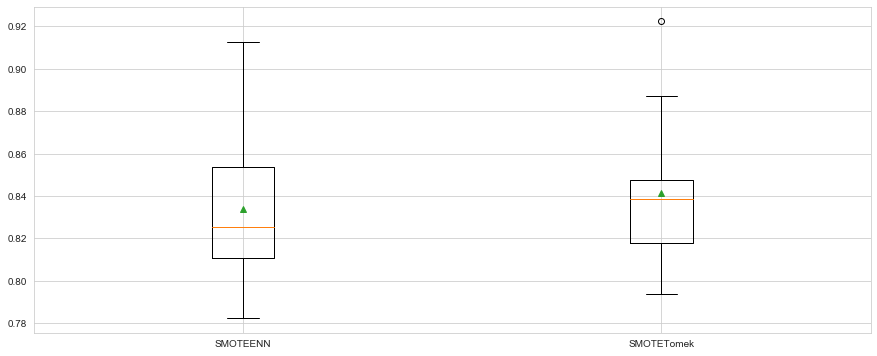

In [94]:
# define models
cmodels, names = get_Cmodels()
results = list()
# evaluate each model
for i in range(len(cmodels)):
    # define the pipeline steps
    steps = [('scale', scaler), ('combined', cmodels[i]), ('m', model)]
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(x, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [95]:
pipe = Pipeline(steps=[('over',SMOTE()),
                ('under',TomekLinks()),
                ('scale',scaler),
                ('clf',model)
               ]
        )

In [96]:
pipe.named_steps

{'over': SMOTE(k_neighbors=5, n_jobs=None, random_state=None, sampling_strategy='auto'),
 'under': TomekLinks(n_jobs=None, sampling_strategy='auto'),
 'scale': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'clf': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

LogisticRegression -> 0.842 (0.028)
[0.84777154 0.8516884  0.80221877 0.80473504 0.90077019 0.86833789
 0.84737603 0.81121715 0.83517515 0.84561023 0.80837858 0.85716709
 0.87943487 0.82116498 0.84273346]


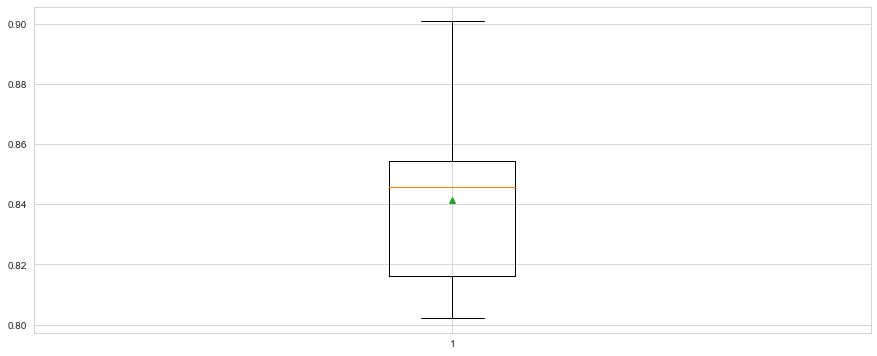

In [97]:
scores = evaluate_model(x,y,pipe)
print(f'{type(pipe["clf"]).__name__} -> {scores.mean().round(3)} ({scores.std().round(3)})')
print(scores)    
plt.boxplot(scores, showmeans=True)
plt.show()

**Threshold Moving**

In [113]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [114]:
pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('under', TomekLinks(n_jobs=None, sampling_strategy='auto')),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [115]:
from sklearn.metrics import roc_curve,confusion_matrix
ypred = pipe.predict_proba(x_test)
yhat = ypred[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, yhat)

Best Threshold=0.682896, G-Mean=0.887


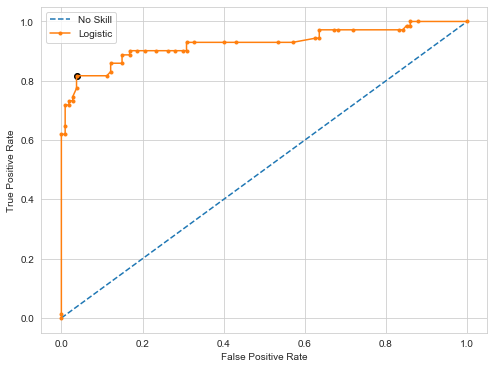

In [118]:
plt.rcParams['figure.figsize']=(8,6)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# calculate the g-mean for each threshold
gmeans  =  np.sqrt(tpr *  (1-fpr))

#Once calculated, we can locate the index for the largest G-mean score and use that index to determine which threshold value to use
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot it on the ROC-AUC curve
plt.scatter(fpr[ix],  tpr[ix],  marker='o',  color='black',  label='Best')

# show the plot
plt.show()

In [119]:
ypred = pipe.predict(x_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       107
           1       0.79      0.87      0.83        71

    accuracy                           0.86       178
   macro avg       0.85      0.86      0.86       178
weighted avg       0.86      0.86      0.86       178



In [132]:
from sklearn.model_selection import cross_validate

ypred = pipe.predict_proba(x_test)

ypred = [1 if i > 0.681 else 0 for i in ypred[:,1].tolist()]

print(classification_report(y_test,ypred))
cross_validate(pipe,x,y,cv=5,scoring=['accuracy','recall','precision'])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       107
           1       0.92      0.80      0.86        71

    accuracy                           0.89       178
   macro avg       0.90      0.88      0.89       178
weighted avg       0.90      0.89      0.89       178



{'fit_time': array([0.0548532 , 0.07180834, 0.06981373, 0.0638299 , 0.0498662 ]),
 'score_time': array([0.00398946, 0.00299096, 0.00299215, 0.00299072, 0.00299263]),
 'test_accuracy': array([0.85955056, 0.84180791, 0.83615819, 0.85875706, 0.89265537]),
 'test_recall': array([0.82352941, 0.80597015, 0.82089552, 0.76470588, 0.86764706]),
 'test_precision': array([0.8115942 , 0.7826087 , 0.76388889, 0.85245902, 0.85507246])}

**Feature strength**

In [122]:
pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('under', TomekLinks(n_jobs=None, sampling_strategy='auto')),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [123]:
ypred = pipe.predict(x_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       107
           1       0.80      0.89      0.84        71

    accuracy                           0.87       178
   macro avg       0.86      0.87      0.86       178
weighted avg       0.87      0.87      0.87       178



In [124]:
pd.DataFrame(clf.coef_,columns=x.columns.to_list()).T.sort_values(0)

NameError: name 'clf' is not defined

**Caliberated**

In [125]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate

#calibrated = CalibratedClassifierCV(pipe, method='sigmoid', cv=3)
calibrated = CalibratedClassifierCV(pipe, method='isotonic', cv=3)

calibrated.fit(x_train, y_train)

ypred = calibrated.predict(x_test)
print(classification_report(y_test,ypred))
cross_validate(pipe,x,y,cv=5,scoring=['accuracy','recall','precision'])
confusion_matrix(y_test,ypred)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       107
           1       0.86      0.85      0.85        71

    accuracy                           0.88       178
   macro avg       0.88      0.88      0.88       178
weighted avg       0.88      0.88      0.88       178



array([[97, 10],
       [11, 60]], dtype=int64)

**Feature Selection**

> Constant & Quasi-Constant Feature

In [133]:
x.std().sort_values()

Cabin_G                   0.067077
Cabin_E                   0.186688
Cabin_D                   0.189471
SurvivalRate              0.206362
Salutation_Master         0.207743
TicketSurvivalRate        0.207955
SurnameSurvivalRate       0.220111
FamilyType_Medium         0.226493
Cabin_ABCT                0.339964
is_married                0.347136
Embarked_C                0.388599
TicketSurvivalRate_NA     0.388599
Age_NA                    0.400056
SurnameSurvivalRate_NA    0.402578
Cabin_M                   0.418301
Pclass_First              0.426191
Embarked_S                0.445246
FamilyType_Small          0.469498
Salutation_Miss/Mrs/Ms    0.477557
Sex_male                  0.477908
FamilyType_Alone          0.489375
Salutation_Mr             0.493815
Pclass_Third              0.497337
Parch                     0.798367
SibSp                     1.105177
FamilySize                1.611560
Age                       1.634804
Fare                      1.936538
TicketFrequency     

> Duplicated Feature

In [134]:
x.T.duplicated().sum()

0

> Correleted Feature

In [135]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in ab
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    return col_corr

In [136]:
corr_features = correlation(x, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  7


In [137]:
corr_features

{'FamilySize',
 'FamilyType_Alone',
 'Salutation_Miss/Mrs/Ms',
 'Salutation_Mr',
 'SurvivalRate',
 'TicketSurvivalRate',
 'TicketSurvivalRate_NA'}

In [138]:
x.drop(labels=corr_features, axis=1, inplace=True)

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [169]:
x_train.head()

,Age,SibSp,Parch,Fare,Age_NA,SurnameSurvivalRate,SurnameSurvivalRate_NA,TicketFrequency,is_married,Pclass_Third,...,Cabin_M,Cabin_ABCT,Cabin_E,Cabin_G,Cabin_D,Embarked_S,Embarked_C,FamilyType_Small,FamilyType_Medium,Salutation_Master
434,2,2,2,1,0,0.00,1,4,0,1,...,1,0,0,0,0,1,0,0,1,0
360,5,0,1,0,0,0.38,0,2,1,1,...,1,0,0,0,0,0,1,1,0,0
355,4,0,0,0,0,0.38,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
81,3,0,0,0,0,0.38,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
838,4,0,0,0,0,0.38,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0


In [170]:
scores = evaluate_model(x,y,pipe)
print(f'{type(pipe["clf"]).__name__} -> {scores.mean().round(3)} ({scores.std().round(3)})')
print(scores)

LogisticRegression -> 0.839 (0.036)
[0.85975062 0.85518611 0.77011691 0.80891551 0.90077019 0.8672595
 0.83430518 0.81928916 0.83517515 0.83759479 0.79537433 0.85407476
 0.89473054 0.78847609 0.86368542]


In [171]:
pipe.fit(x_train,y_train)
ypred = pipe.predict(x_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       107
           1       0.83      0.89      0.86        71

    accuracy                           0.88       178
   macro avg       0.88      0.88      0.88       178
weighted avg       0.88      0.88      0.88       178



> Remove features using univariate roc_auc

In [172]:
from sklearn.metrics import roc_auc_score

In [173]:
roc_values = []
for feature in x_train.columns:
    pipe.fit(x_train[feature].to_frame(), y_train)
    y_scored = pipe.predict_proba(x_test[feature].to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

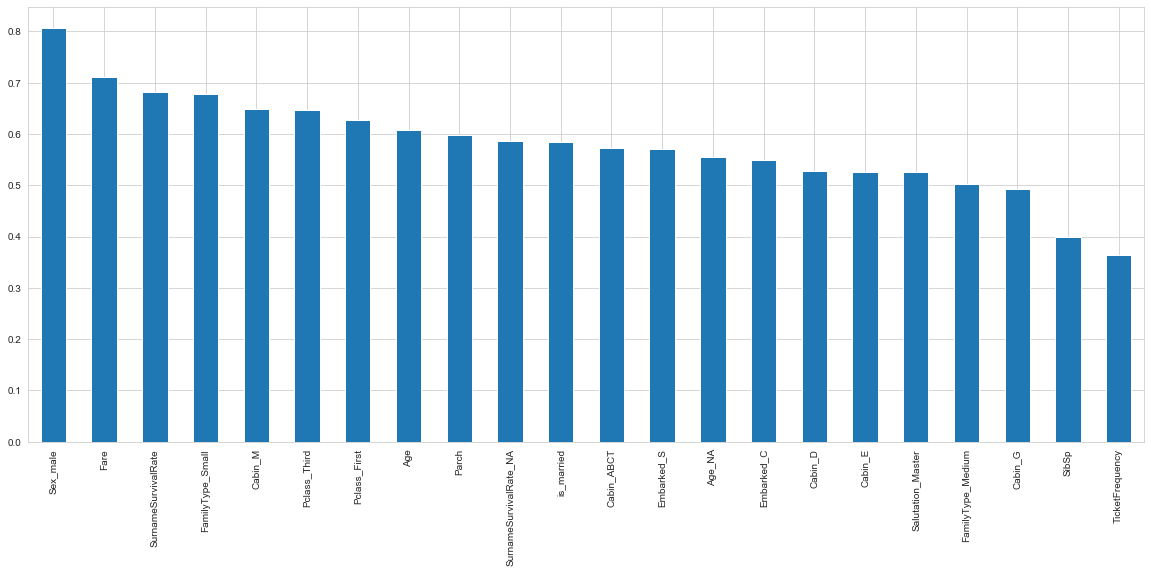

In [174]:
roc_values = pd.Series(roc_values)
roc_values.index = x_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [175]:
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), x_train.shape[1]

(19, 22)

In [176]:
selected_feat = selected_feat.index.to_list()
selected_feat

['Age',
 'Parch',
 'Fare',
 'Age_NA',
 'SurnameSurvivalRate',
 'SurnameSurvivalRate_NA',
 'is_married',
 'Pclass_Third',
 'Pclass_First',
 'Sex_male',
 'Cabin_M',
 'Cabin_ABCT',
 'Cabin_E',
 'Cabin_D',
 'Embarked_S',
 'Embarked_C',
 'FamilyType_Small',
 'FamilyType_Medium',
 'Salutation_Master']

In [177]:
scores = evaluate_model(x[selected_feat],y,pipe)
print(f'{type(pipe["clf"]).__name__} -> {scores.mean().round(3)} ({scores.std().round(3)})')
print(scores)

LogisticRegression -> 0.838 (0.034)
[0.85319469 0.86386843 0.7857275  0.80891551 0.90077019 0.86277751
 0.83868476 0.80702479 0.82754782 0.8295019  0.8040672  0.83430518
 0.89473054 0.78847609 0.86672617]


> Step forward feature selection

In [178]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [179]:
sfs1 = SFS(pipe,
            k_features=15,
            forward=True,
            floating=False,
            verbose=2,
            scoring='roc_auc',
            cv=3,
           n_jobs=-1
          )


In [180]:
fs1 = sfs1.fit(x[selected_feat],y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.2s finished

[2020-04-08 17:03:36] Features: 1/15 -- score: 0.7678658889670061[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.3s finished

[2020-04-08 17:03:37] Features: 2/15 -- score: 0.8293313625580057[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.2s finished

[2020-04-08 17:03:37]

In [181]:
selected_feat= x.columns[list(sfs1.k_feature_idx_)].to_list()
selected_feat

['Age',
 'Parch',
 'Age_NA',
 'SurnameSurvivalRate',
 'SurnameSurvivalRate_NA',
 'TicketFrequency',
 'is_married',
 'Pclass_Third',
 'Pclass_First',
 'Sex_male',
 'Cabin_M',
 'Cabin_E',
 'Cabin_G',
 'Embarked_S',
 'Embarked_C']

In [182]:
scores = evaluate_model(x[selected_feat],y,pipe)
print(f'{type(pipe["clf"]).__name__} -> {scores.mean().round(3)} ({scores.std().round(3)})')
print(scores)

LogisticRegression -> 0.826 (0.038)
[0.8388941  0.81538796 0.76985258 0.79206126 0.90077019 0.87752691
 0.84641474 0.78633168 0.80523785 0.83759479 0.78334945 0.85264375
 0.86292551 0.78021957 0.83960582]


> Modeling

In [183]:
pipe.fit(x_train[selected_feat],y_train)

Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('under', TomekLinks(n_jobs=None, sampling_strategy='auto')),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [184]:
from sklearn.metrics import roc_curve,confusion_matrix
ypred = pipe.predict_proba(x_test[selected_feat])
yhat = ypred[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, yhat)

Best Threshold=0.600163, G-Mean=0.887


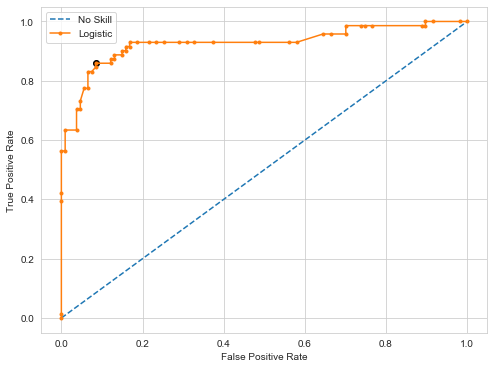

In [185]:
plt.rcParams['figure.figsize']=(8,6)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# calculate the g-mean for each threshold
gmeans  =  np.sqrt(tpr *  (1-fpr))

#Once calculated, we can locate the index for the largest G-mean score and use that index to determine which threshold value to use
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot it on the ROC-AUC curve
plt.scatter(fpr[ix],  tpr[ix],  marker='o',  color='black',  label='Best')

# show the plot
plt.show()

In [189]:
ypred = pipe.predict_proba(x_test[selected_feat])

ypred = [1 if i > 0.60 else 0 for i in ypred[:,1].tolist()]

print(classification_report(y_test,ypred))
cross_validate(pipe,x,y,cv=5,scoring=['accuracy','recall','precision'])

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       107
           1       0.87      0.86      0.87        71

    accuracy                           0.89       178
   macro avg       0.89      0.89      0.89       178
weighted avg       0.89      0.89      0.89       178



{'fit_time': array([0.05533648, 0.05966187, 0.0872333 , 0.10181022, 0.10808611]),
 'score_time': array([0.00413108, 0.0039258 , 0.00697923, 0.01038599, 0.00723481]),
 'test_accuracy': array([0.85393258, 0.83050847, 0.83050847, 0.83615819, 0.89265537]),
 'test_recall': array([0.82352941, 0.80597015, 0.80597015, 0.70588235, 0.85294118]),
 'test_precision': array([0.8       , 0.76056338, 0.76056338, 0.84210526, 0.86567164])}

In [190]:
pipe.fit(x[selected_feat],y)

Pipeline(memory=None,
         steps=[('over',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('under', TomekLinks(n_jobs=None, sampling_strategy='auto')),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [193]:
ypred = pipe.predict_proba(test[selected_feat])

In [194]:
ypred = [1 if i > 0.60 else 0 for i in ypred[:,1].tolist()]

In [195]:
a = pd.DataFrame(pd.read_csv('test_imputed.csv')['PassengerId'])
a['Survived'] = pd.DataFrame(ypred)
a.to_csv("submit.csv", index=False)

75.5